<font size = '3'> **Finding the coordinates of the phone using a Bayesian Model**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from os import walk, path, listdir
from os.path import isfile, join
import random
import matplotlib.image as img
from PIL import Image, ImageDraw

<u> Get the filenames and coordinates for each file </u>

Image files

In [2]:
#get current directory 
current_dir = os.getcwd()

#find phone directory
find_phone_dir = current_dir + '\\find_phone'

#get the file names in the find phone directory
filenames = [f for f in listdir(find_phone_dir) if isfile(join(find_phone_dir, f))]

#get the image names
labels_file = filenames.pop(len(filenames)-1)

#number of samples
num_samples = len(filenames)

Get info from the labels file

In [3]:
#get the label files
label = open(find_phone_dir + '\\' + str(labels_file), 'r')
labels = label.read()
label_list = labels.split('\n')

#delete the last element ('')
label_list.pop()

#put the labels to a dictionary
#add file name and coordinates to a dictionary 
coords = {}

for name in label_list:
    
    name_split = name.split(' ')
    coords[name_split[0]] = tuple((float(name_split[1]), float(name_split[2])))

Get data to numpy arrays

In [4]:
#get all the images to one vector
X = np.zeros([num_samples, 326, 490, 3])

#create vector for Y for x and y coordinates
Y = np.zeros([num_samples, 2])

for i in range(len(filenames)):
    
    im = img.imread(find_phone_dir + '\\' + filenames[i])   
    X[i, :] = im
    Y[i, 0] = coords[filenames[i]][0]
    Y[i, 1] = coords[filenames[i]][1]

<u> Useful functions </u>

In [5]:
#convert the data to black and white
def to_bandw(X, alpha):
    """
    X - data
    alpha - is the threshold to set either black or white
    """
    
    #convert the images to gray scale
    rgb_weights = [0.2989, 0.5870, 0.1140]
    
    #convert to gray scale
    X = X @ rgb_weights

    #black and white image
    X[X <= alpha] = 0 #black
    X[X > alpha] = 255 #white

    return X

In [6]:
#create a 32 x 48 matrix that has the pixels of the phone. This function will be used to find the prior distribution
#create the box
def box_mat(X, Y, rad = 0.05):
    """
    X - the data
    Y - labels/coordinates
    rad - is the scaling factor of the rctangle
    """
    
    #rectangle length
    x_rad = math.floor(rad * 490)
    y_rad = math.floor(rad * 326)
    
    #actual location of the phone
    x_0, y_0 = Y[0], Y[1]    
    x_0 = x_0 * 490
    y_0 = y_0 * 326
    
    
    #boundaries
    x1 = math.floor(x_0 - x_rad)
    x2 = math.floor(x_0 + x_rad)
    y1 = math.floor(y_0 - y_rad)
    y2 = math.floor(y_0 + y_rad)
    
    mat = X[y1:y2, x1:x2]
    
    return mat.astype('uint8')

In [7]:
#calculate the prior
def calc_prior(X, Y):
    """
    X - pixel data
    Y - coordinates
    """
    #create an empty matrix for the prior
    prior = np.zeros([32, 48])

    #collect the pictures
    for i in range(len(X)):

        X_i = X[i]
        Y_i = Y[i]

        try:

            mat = box_mat(X_i, Y_i)
            prior += mat

        except:
            
            pass
            
    #normalize m
    prior = prior/len(X)   
    
    return prior

In [8]:
#calculate the posterior

def calc_post(prior, like):
    
    rows = np.arange(0, prior.shape[0] * math.floor(like.shape[0]/prior.shape[0]), prior.shape[0])
    cols = np.arange(0, prior.shape[1] * math.floor(like.shape[1]/prior.shape[1]), prior.shape[1])
    
    
    
    #posterior matrix
    x_post = np.zeros([max(rows), max(cols)])

    for r in range(len(rows) - 1):

        for c in range(len(cols) - 1):

            likelihood = like[rows[r]: rows[r + 1], cols[c]: cols[c + 1]]
            post = likelihood * prior
            
            #normalized posterior
            post_n = post

            x_post[rows[r]: rows[r + 1], cols[c]: cols[c + 1]] = post_n
            
    return x_post

<u> Bayesian Model to predict phone coordinates </u>

I used several deep learning methods to estimate the coordinates. But because of the low sample size the estimates were erroneous. So I am using a much simpler Bayesian method to estimate the the coordinates. (Which did a pretty decent job at estimating testing coordinates).

Bayesian models have three components. The prior, the likelihood and the posterior. The prior contains information we already have, the likelihood contains the data we have and we use the prior (already known) data to modulate the likelihood (new data) and come to a conclusion (posterior). 

We can represent these three using probability distributions. So I will use the training set to come up with a prior distribution that ideally represent the probability of the phone, P(phone). Then I will use the current data and use the prior to calculate a posterior probability distribution. This posterior distribution will give you the probability of a pixel being the phone, P(phone|pixel). 

Below are the steps I took to develop the model.

1) Turn the data into grayscale and then black and white. 

    Since the phone was white and black I thought this would be helpful to detect where the phone is in the picture. So I will be turning the pictures to black and white. I will use a threshold (which will be a hyper parameter (alpha) which we can tune later on) if a pixel is assigned white or black. 
    
2) Get the testing data and create a Prior. 

    Next I will create the Prior of the model. I will use the training data to do this. I will first capture the pixels about the phone creating a rectangle about the phone. (2 * 0.05 * 490 X 2 * 0.05 * 326 Roughly 32 x 48) and find the Prior probability. 
    
3) Using the prior to scan through the data and find the estimation.

    To calculate the posterior probability, I will first create subsections of the picture that are same size of the prior. (32 x 48). Then will calculate the posterior probability in each subsection. Finally will use the posterior find the pixel that has the highest probability. This will represent the location of the phone.
    
    
We will use roughly 75% of the data as training, 25% testing. The validation data will be used for the hyperparameter tuning and the final prior with the chosen hyper parameter will be used to evaluate the testing data.

<u> Applying the model </u>

Split to train, test data. (75% and 25% split)

In [9]:
#train set
x_train = X[:100]
y_train = Y[:100]

#validation set
#x_val = X[75:102]
#y_val = Y[75:102]

#test set
x_test = X[100:129]
y_test = Y[100:129]

Apply the model

In [10]:
#We will choose a range of parameters for alpha. from 0 - 255
alphas = np.array([0.5, 1, 5, 10, 12, 15, 20, 25, 35, 50, 75, 100, 130, 150, 180, 200, 220])

#dictionary to collect values
all_data = {}

for alpha in alphas:   
    #dict for data
    data = {}   
    
    #change picture to black and white
    x_train_bw = to_bandw(x_train, alpha)
    
    #calculate prior
    prior = calc_prior(x_train_bw, y_train)
    prior = prior/255 #normalize
    
    #plt.imshow(x_train_bw[10].astype('uint8'), cmap = plt.get_cmap('gray'))
    #plt.imshow(prior)
    
    #use the prior to calculate the posterior
    x_val_bw = to_bandw(x_test, alpha)
    
    #list to append correct detection
    correct = []
    distance = []
    estimate = []
    actual = []
    
    for s in range(len(x_val_bw)):
        
        likelihood = x_val_bw[s]/255 #normalize
        
        #changing the probabilities. (right now we have the probability of white space. We want to calculate the probability\
        #of black areas)
        prior = 1 - prior
        likelihood = 1 - likelihood        
        
        posterior = calc_post(prior, likelihood)
               
        #find the estimate
        phone_x = np.round(np.where(posterior == np.max(posterior))[1][0]/490, 4)
        phone_y = np.round(np.where(posterior == np.max(posterior))[0][0]/326, 4)
        
        #calculate if the phone is inside the detection threshold (0.05)
        dist = ((phone_x - y_test[s][0])**2 + (phone_y - y_test[s][1])**2)**0.5
        dist = np.round(dist, 4)
        
        #estimate
        estimate.append(tuple((phone_x, phone_y)))
        
        #actual
        actual.append(tuple((y_test[s][0], y_test[s][1])))
        
        
        #find if correct or not
        if dist <= 0.05:
            correct.append(1)
        else:
            correct.append(0)
        
        distance.append(dist)
    
    
    #get the data
    data['ALPHA'] = alpha
    data['DISTANCE'] = distance
    data['ACCURACY'] = np.sum(correct)/len(correct)
    data['PRIOR'] = prior
    data['ESTIMATE'] = estimate
    data['ACTUAL'] = actual
    
    #all data
    all_data['ALPHA' + str(alpha)] = data

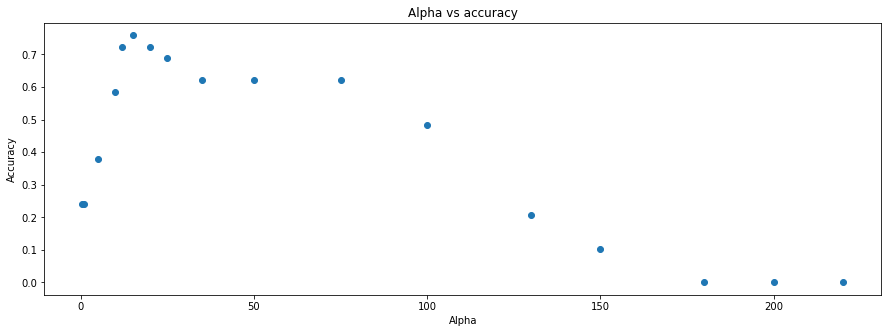

In [11]:
A = []
ALP = []

#plot accuracy and alpha
for alpha in alphas:
    name = 'ALPHA' + str(alpha)
    
    data = all_data[name]
    
    #accuracy
    A.append(data['ACCURACY'])
    ALP.append(alpha)
    
#plot
plt.figure(figsize = (15, 5))
plt.title('Alpha vs accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.scatter(ALP, A)
plt.show()

Looks like alpha = 15 gives the highest accuracy (75%) on testing sample. 

Lets plot actual vs predicted on some images using alpha = 15

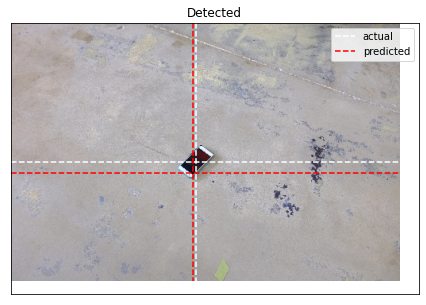

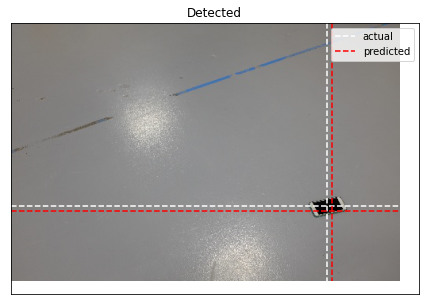

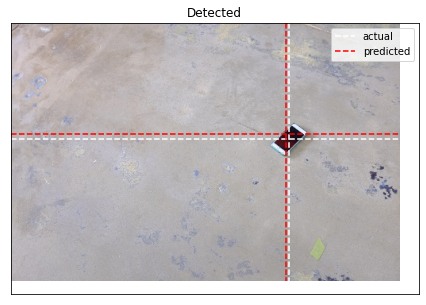

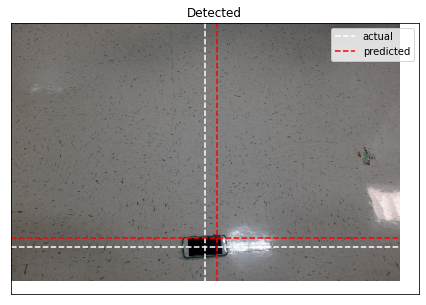

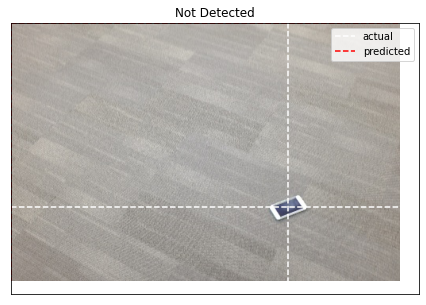

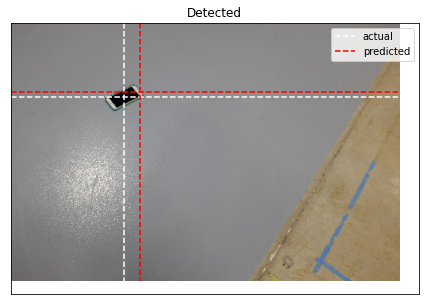

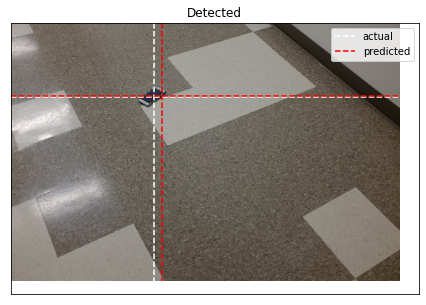

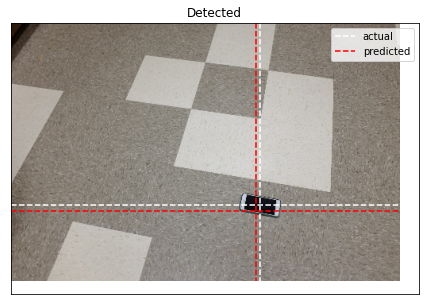

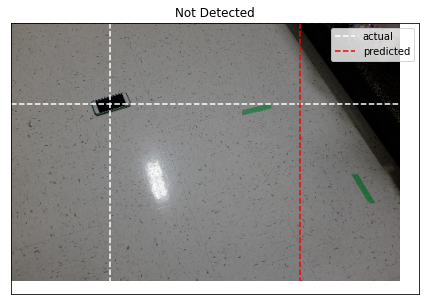

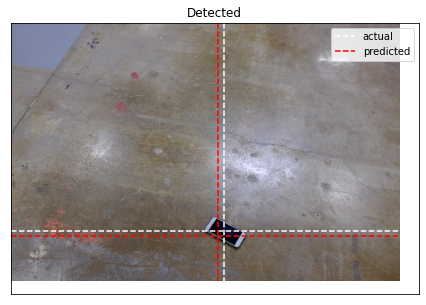

In [12]:
#get data from ALPHA15
prior = all_data['ALPHA15.0']['PRIOR']

#use the prior to calculate the posterior
x_val_bw = to_bandw(x_test, 15)

for s in range(len(x_val_bw)):
    
    #calculate the posterior
    likelihood = x_val_bw[s]/255 #normalize
    prior = 1 - prior
    likelihood = 1 - likelihood        
    posterior = calc_post(prior, likelihood)

    #find the estimate
    phone_x = np.round(np.where(posterior == np.max(posterior))[1][0]/490, 4)
    phone_y = np.round(np.where(posterior == np.max(posterior))[0][0]/326, 4)
    
    #detect
    detect = ((phone_x - Y[100 + s][0])**2 + (phone_y - Y[100 + s][1])**2)**0.5
    
    d = 1 if detect < 0.05 else 0
    
    #plot some samples
    if s % 3 == 0:
        plt.figure(figsize = (8, 5))
        plt.imshow(X[100 + s].astype('uint8'))
        
        #actual line
        plt.hlines(y = Y[100 + s][1] * 326, xmin = 0, xmax = 490, linestyle = '--', color = 'w', label = 'actual')
        plt.vlines(x = Y[100 + s][0] * 490, ymin = 0, ymax = 326, linestyle = '--', color = 'w')
        
        #predicted line
        plt.hlines(y = phone_y * 326, xmin = 0, xmax = 490, linestyle = '--', color = 'r', label = 'predicted')
        plt.vlines(x = phone_x * 490, ymin = 0, ymax = 326, linestyle = '--', color = 'r')
        
        plt.legend()
        if d == 1:
            plt.title('Detected')
        else:
            plt.title('Not Detected')
        plt.xticks([])
        plt.yticks([])